# Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.drop(["PassengerId", "Ticket"], axis=1, inplace=True)
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From this, we can draw several quick observations:

1. Roughly 38% of passengers survived


2. The average passenger is around 30 years old, but there is high variance as standard deviation is >14.5. There are babies and elderly onboard as the minimum age is <1 and the oldest person onboard is 80 years old. However, most passengers (up to the 75th percentile) are <39 years old.


3. Most people only brought 1 spouse/sibling onboard (up to 75th percentile). However, there are a few who brought a large family (up to 8 spouse + siblings). 


4. Most people did not bring their parents or children onboard (up to 75th percentile). But again, there are a few who brought a large family (up to 6 parents + children). 


5. Most people paid a relatively low fare (lower than the mean) for their tickets (75% paid 31 dollars or less while the mean is 32.2 dollars). However, there are a few passengers who paid an exorbitant price for their tickets (up to 512 dollars), possibly indicating the presence of VIPs.

In [5]:
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

# Dealing with missing values

First, we are going to deal with the missing "Age" data. There are a few ways to impute the data, most commonly using the mean or the median. However, the mean is easily affected by extreme values and while the median is generally a good representation of our age distribution, we want a value that can represent the different demographics of our passengers. Hence, we will use salutations (Mr, Ms, Mdm etc) as a separator for the different demographics.

Let's first extract the salutations from our dataset.

In [6]:
import re
df_train["Salutations"] = df_train["Name"].str.extract(r'([A-Z]{1}[a-z]+\.)')

In [7]:
df_train["Salutations"].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.'], dtype=object)

From salutations alone, we managed to glean even more interesting data. It seems that there are nobility (Don, Countess and Jonkheer) and military personnel (Major, Col, Capt) onboard. There are also French equivalent of English salutations (Mme = Mrs, Mlle = Ms) and clergymen present(Rev, possibly Don). Let's further explore the salutations that are age significant (Master, Miss, Mister, Mrs).

In [8]:
df_train[df_train["Salutations"] == "Master."]["Age"].median()

3.5

In [9]:
df_train[(df_train["Salutations"] == "Miss.") | (df_train["Salutations"] == "Ms.") | (df_train["Salutations"] == "Mlle.")]["Age"].median()

21.0

In [10]:
df_train[df_train["Salutations"] == "Mr."]["Age"].median()

30.0

In [11]:
df_train[(df_train["Salutations"] == "Mrs.") | (df_train["Salutations"] == "Mme.")]["Age"].median()

35.0

As we can see from their median values, each salutation represents a different age group. It is also reasonable to assume that high-ranking military personnel and nobility are usually older, so we shall group them along with other uncommon titles such as Rev and Dr. Let's now create a new feature column with these categories.

In [12]:
master = (df_train["Salutations"] == "Master.")
miss = (df_train["Salutations"] == "Miss.") | (df_train["Salutations"] == "Ms.") | (df_train["Salutations"] == "Mlle.")
mister = (df_train["Salutations"] == "Mr.")
missus = (df_train["Salutations"] == "Mrs.") | (df_train["Salutations"] == "Mme.")

In [13]:
df_train["Title"] = "Others"
df_train["Title"][master] = "Master"
df_train["Title"][miss] = "Miss"
df_train["Title"][mister] = "Mister"
df_train["Title"][missus] = "Missus"

We will now fill in the missing values for "Age" according to their titles. We will use the median for each demographic as a replacement.

In [14]:
df_train["Age"] = df_train.groupby("Title")["Age"].apply(lambda x: x.fillna(x.median()))

Now we have to deal with the missing data for "Cabin". A large proportion of it is missing, but the little amount of data that we have is important as the first letter of each cabin represents the deck. 'A' is at the top, 'B' is below 'A' and so on. We will replace all missing values with 'Z' and come back to analyze this later on.

In [15]:
df_train["Cabin"] = df_train["Cabin"].str.extract(r'([A-Z]{1})').fillna('Z')

Finally, we have to deal with 2 missing values in "Embarked". Let's just replace them with the most common value.

In [16]:
df_train["Embarked"].mode()

0    S
dtype: object

In [17]:
df_train["Embarked"] = df_train["Embarked"].fillna('S')

Now, let's check our dataset before we start analysing the data.

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        891 non-null    object 
 9   Embarked     891 non-null    object 
 10  Salutations  891 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


Great. We managed to replace all missing values. Let's drop the irrelevant features in our dataset and take a final look at our clean data.

In [19]:
df_train.drop(["Name", "Salutations"], axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,Z,S,Mister
1,1,1,female,38.0,1,0,71.2833,C,C,Missus
2,1,3,female,26.0,0,0,7.9250,Z,S,Miss
3,1,1,female,35.0,1,0,53.1000,C,S,Missus
4,0,3,male,35.0,0,0,8.0500,Z,S,Mister


# Data Visualisation & Feature Engineering

We will take a look at each feature and see how they relate to survival.

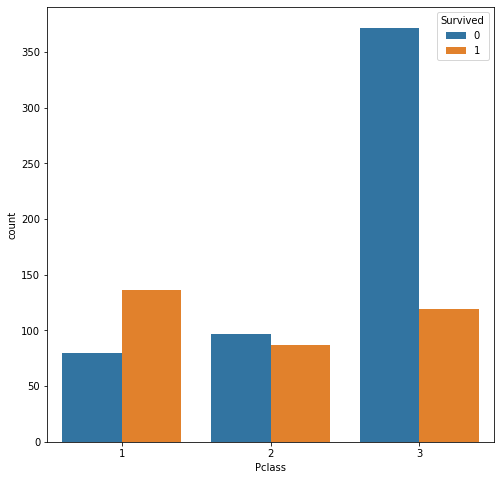

In [20]:
plt.figure(figsize=(8,8))
sns.countplot("Pclass", data=df_train, hue="Survived")

Next, let's take a look at sex and see how it affects survival.

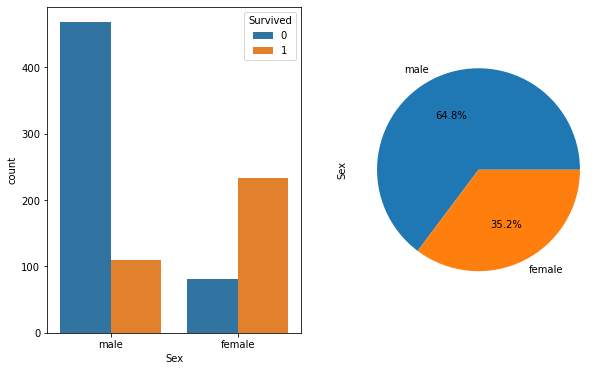

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 6))
ax=sns.countplot("Sex", data=df_train, hue="Survived", ax = axes[0])
ax1=df_train["Sex"].value_counts().plot.pie(autopct='%1.1f%%', ax = axes[1])

It is evident that females have a higher rate of survival as compared to men (65% of passengers were male and most of them did not survive). Let's convert this categorical data to numerical. 1 for female, and 0 for men.

In [22]:
sex = {"male": 0, "female": 1}
df_train["Sex"] = df_train["Sex"].map(sex)

Next, we want to see how age affects chances of survival. This is especially important as we previously identified that there is high variance in age, that 75% of passengers are <39 years old, and there are babies and elderly onboard. We want to see how those factors are related to survival. Let's first plot the distribution of age against survival.

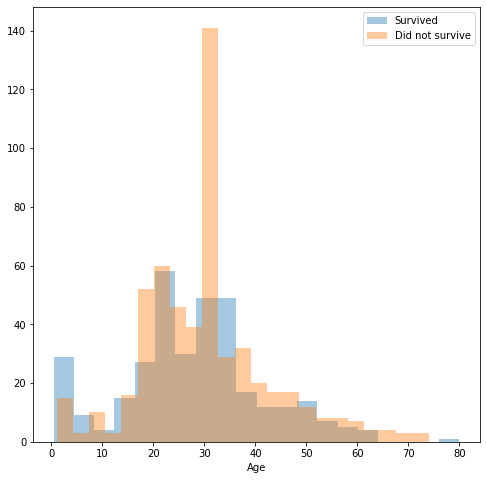

In [23]:
plt.figure(figsize=(8,8))
survived = df_train[df_train["Survived"] == 1]
not_survived =  df_train[df_train["Survived"] == 0]

sns.distplot(survived["Age"], kde=False, label='Survived')
sns.distplot(not_survived["Age"], kde=False, label='Did not survive')
plt.legend()

It is difficult to relate survival with age alone as they seem to follow the same distribution. Let's try including sex as a factor as we saw that 65% of survivors were female.

Text(0.5, 1.0, 'Male')

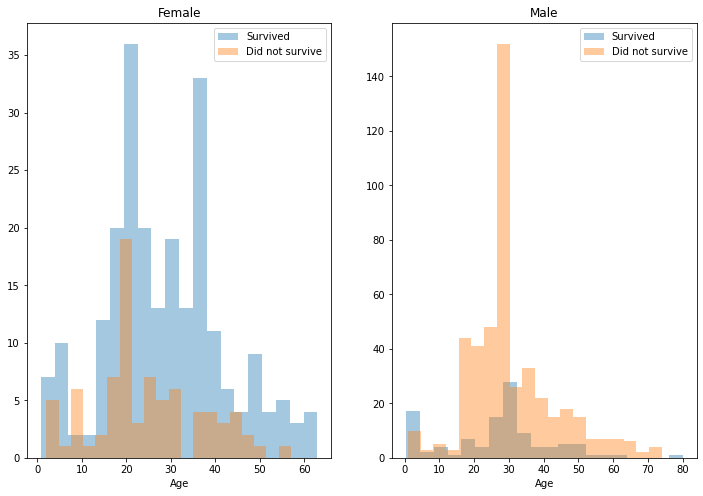

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 8))
men = df_train[df_train["Sex"] == 0]
women = df_train[df_train["Sex"] == 1]

ax = sns.distplot(women[women['Survived']==1]["Age"], label="Survived", ax=axes[0], kde=False, bins=20)
ax1 = sns.distplot(women[women['Survived']==0]["Age"], label="Did not survive", ax=axes[0], kde=False, bins=20)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1]["Age"], label="Survived", ax=axes[1], kde=False, bins=20)
ax1 = sns.distplot(men[men['Survived']==0]["Age"], label="Did not survive", ax=axes[1], kde=False, bins=20)
ax.legend()
ax.set_title('Male')

Awesome. Now we can see that majority of both genders age <8 has a high survival rate, women have a high survival rate between age 14 - 40, and men aged slightly <30 have the highest risk of dying. Let's translate age into a equal-sized feature column with the help of qcut function from pandas.

In [25]:
pd.qcut(df_train[df_train["Age"]>8]["Age"], 5)

0       (21.0, 28.0]
1       (30.0, 39.0]
2       (21.0, 28.0]
3       (30.0, 39.0]
4       (30.0, 39.0]
           ...      
886     (21.0, 28.0]
887    (8.999, 21.0]
888    (8.999, 21.0]
889     (21.0, 28.0]
890     (30.0, 39.0]
Name: Age, Length: 833, dtype: category
Categories (5, interval[float64]): [(8.999, 21.0] < (21.0, 28.0] < (28.0, 30.0] < (30.0, 39.0] < (39.0, 80.0]]

In [26]:
age = (df_train["Age"] < 8)
age1 = (df_train["Age"] >= 9) & (df_train["Age"] < 21)
age2 = (df_train["Age"] >= 21) & (df_train["Age"] < 28)
age3 = (df_train["Age"] >= 28) & (df_train["Age"] < 30)
age4 = (df_train["Age"] >= 28) & (df_train["Age"] < 39)
age5 = (df_train["Age"] >= 39)

In [27]:
df_train["Age"][age] = 0
df_train["Age"][age1] = 1
df_train["Age"][age2] = 2
df_train["Age"][age3] = 3
df_train["Age"][age4] = 4
df_train["Age"][age5] = 5

Next, we will combine the number of sibilings/spouses and parents/children to get the total number of family members onboard. Then we will take a look at how that relates to survival.

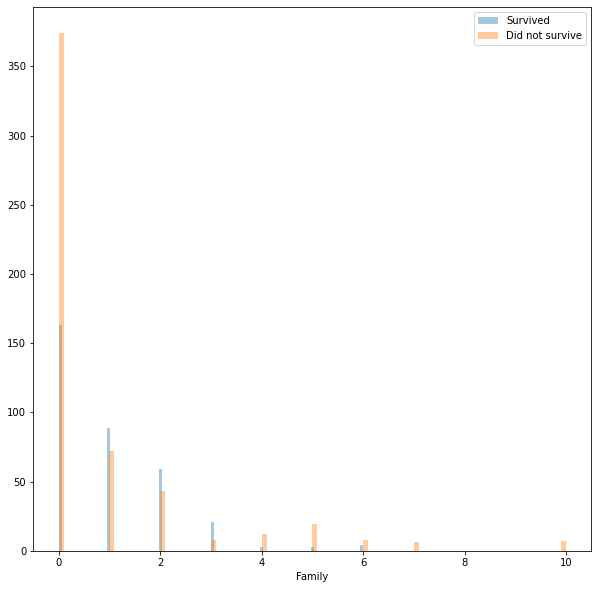

In [28]:
plt.figure(figsize=(10, 10))
df_train["Family"] = df_train["SibSp"] + df_train["Parch"]
survived = df_train[df_train["Survived"] == 1]
not_survived =  df_train[df_train["Survived"] == 0]

sns.distplot(survived["Family"], kde=False, label="Survived", bins=100)
sns.distplot(not_survived["Family"], kde=False, label="Did not survive", bins=100)
plt.legend()

From here, we can see that your chances of survival is lowest when you have no family and have 4 or more family members. Let's reflect that as a feature column.

In [29]:
none = (df_train["Family"] == 0)
four = (df_train["Family"] >= 4)

df_train["Fam_Cat"] = 1
df_train["Fam_Cat"][none] = 0
df_train["Fam_Cat"][four] = 2

Now we will look at how Fare paid affects your chances of survival.

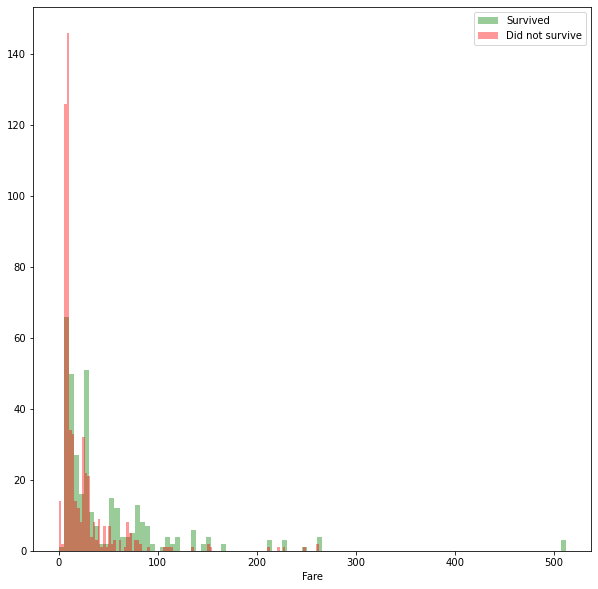

In [30]:
plt.figure(figsize=(10, 10))
survived = df_train[df_train["Survived"] == 1]
not_survived =  df_train[df_train["Survived"] == 0]

sns.distplot(survived["Fare"], kde=False, label='Survived', bins=100, color='green')
sns.distplot(not_survived["Fare"], kde=False, label='Did not survive', bins=100, color='red')
plt.legend()

From here, we can see that if you paid less, your relative chances of survival decreased. This is especially so when you paid <10, and between 10 - 20. Your chances of survival increased when you paid more than $50. Let's classify this into equal categories (like age).

In [31]:
pd.qcut(df_train["Fare"], 6)

0        (-0.001, 7.775]
1      (52.369, 512.329]
2         (7.775, 8.662]
3      (52.369, 512.329]
4         (7.775, 8.662]
             ...        
886      (8.662, 14.454]
887       (26.0, 52.369]
888       (14.454, 26.0]
889       (26.0, 52.369]
890      (-0.001, 7.775]
Name: Fare, Length: 891, dtype: category
Categories (6, interval[float64]): [(-0.001, 7.775] < (7.775, 8.662] < (8.662, 14.454] < (14.454, 26.0] < (26.0, 52.369] < (52.369, 512.329]]

In [32]:
fare = (df_train["Fare"] < 7.775)
fare1 = (df_train["Fare"] >= 7.775) & (df_train["Fare"] < 8.662)
fare2 = (df_train["Fare"] >= 8.662) & (df_train["Fare"] < 14.454)
fare3 = (df_train["Fare"] >= 14.454) & (df_train["Fare"] < 26)
fare4 = (df_train["Fare"] >= 26) & (df_train["Fare"] < 52.369)
fare5 = (df_train["Fare"] >= 52.369)

df_train["Fare"][fare] = 0
df_train["Fare"][fare1] = 1
df_train["Fare"][fare2] = 2
df_train["Fare"][fare3] = 3
df_train["Fare"][fare4] = 4
df_train["Fare"][fare5] = 5

Now, let's analyze the port of embarkation.

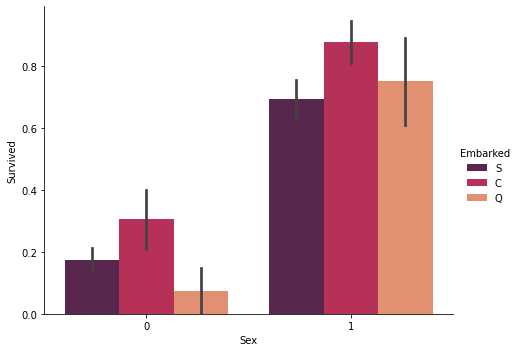

In [33]:
sns.catplot(x='Sex', y='Survived', kind='bar', data=df_train, hue='Embarked', palette='rocket', aspect=1.3)

Survival rate seems to be highest if embarked from C, and uncertain if embarked from S and Q. Since there are only 3 ports, let's convert this to numeric values.

In [34]:
port = {'S': 1, 'C': 2, 'Q': 3}
df_train["Embarked"] = df_train["Embarked"].map(port)

Finally, let's convert Cabin categories to numbers. Since A is nearest to the top, we can assume that passengers in Cabin A have the highest chance of survival, followed by B and then C and so on. We won't analyse this as there is too much missing data to draw conclusions about the overall population of passengers.

In [35]:
df_train["Cabin"].unique()

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [36]:
cabin = {"Z": 8, "T": 7, "G": 6, "F": 5, "E": 4, "D": 3, "C": 2, "B": 1, "A": 0}
df_train["Cabin"] = df_train["Cabin"].map(cabin)

Let's drop all irrelevant columns and prep our data for model building.

In [37]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family,Fam_Cat
0,0,3,0,2.0,1,0,0.0,8,1,Mister,1,1
1,1,1,1,4.0,1,0,5.0,2,2,Missus,1,1
2,1,3,1,2.0,0,0,1.0,8,1,Miss,0,0
3,1,1,1,4.0,1,0,5.0,2,1,Missus,1,1
4,0,3,0,4.0,0,0,1.0,8,1,Mister,0,0


In [38]:
df = df_train.drop(["SibSp", "Parch", "Family"], axis=1)
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fam_Cat
0,0,3,0,2.0,0.0,8,1,Mister,1
1,1,1,1,4.0,5.0,2,2,Missus,1
2,1,3,1,2.0,1.0,8,1,Miss,0
3,1,1,1,4.0,5.0,2,1,Missus,1
4,0,3,0,4.0,1.0,8,1,Mister,0


Let's map our "Title" category and create a few final features for Pclass, Sex, Age and Fare as these seem to be the most important features.

In [39]:
title = {"Master": 0, "Miss": 1, "Mister": 3, "Missus": 4, "Others": 5}
df["Title"] = df["Title"].map(title)


df["Age"] = df["Age"].astype(int)
df["Fare"] = df["Fare"].astype(int)

df["Pclass_Sex"] = df["Pclass"]*df["Sex"]
df["Pclass_Age"] = df["Pclass"]*df["Age"]
df["Pclass_Fare"] = df["Pclass"]*df["Fare"]
df["Sex_Age"] = df["Sex"]*df["Age"]
df["Sex_Fare"] = df["Sex"]*df["Fare"]
df["Age_Fare"] = df["Age"]*df["Fare"]

In [40]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fam_Cat,Pclass_Sex,Pclass_Age,Pclass_Fare,Sex_Age,Sex_Fare,Age_Fare
0,0,3,0,2,0,8,1,3,1,0,6,0,0,0,0
1,1,1,1,4,5,2,2,4,1,1,4,5,4,5,20
2,1,3,1,2,1,8,1,1,0,3,6,3,2,1,2
3,1,1,1,4,5,2,1,4,1,1,4,5,4,5,20
4,0,3,0,4,1,8,1,3,0,0,12,3,0,0,4


# Model Building and Training

In [41]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [44]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[101  12]
 [ 19  47]]


0.8268156424581006

In [46]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 80.90 %
Standard Deviation: 1.44 %


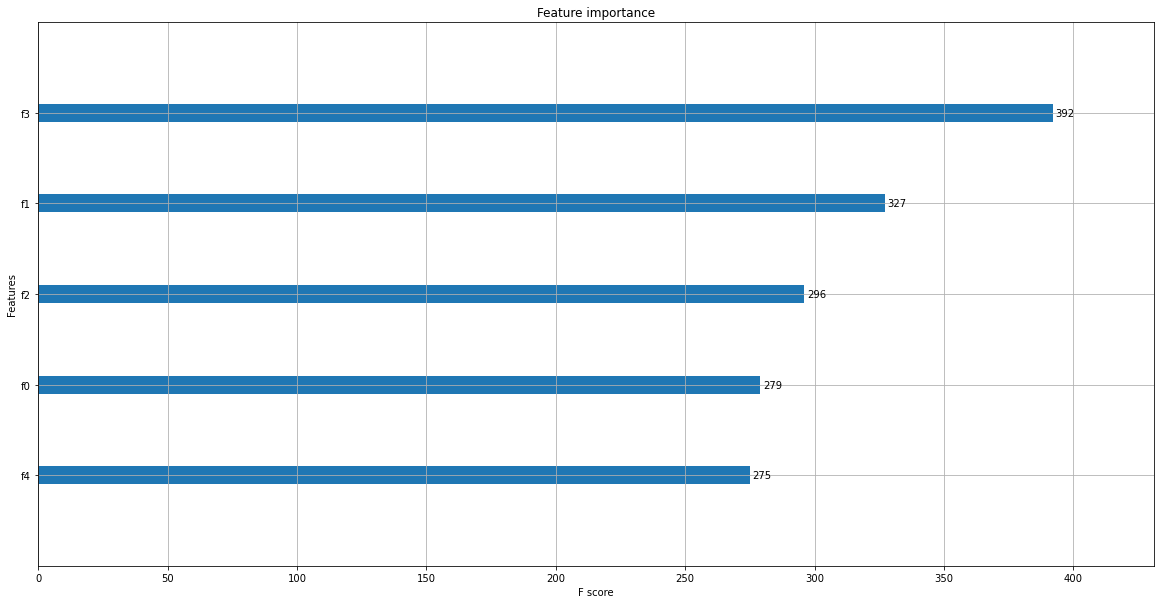

In [47]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(classifier, ax=ax)

Results seem decent, but definitely can be tweaked. Let's try a Grid Search with different parameter values.

In [48]:
params = {
        'min_child_weight': [1, 2, 3],
        'learning_rate': [0.2, 0.3, 0.02, 0.03],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6],
        'n_estimators': [100, 300, 500, 700]
        }

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
grid = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', n_jobs=4, cv=3, verbose=3)
grid.fit(X, y)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_)
print('\n Best parameters:')
print(grid.best_params_)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed:  6.3min



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best score:
0.840628507295174

 Best parameters:
{'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


[Parallel(n_jobs=4)]: Done 3888 out of 3888 | elapsed:  6.3min finished


# Model Testing and Predictions

In [50]:
df_test = pd.read_csv("../input/titanic/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [51]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [52]:
df_test["Salutations"] = df_test["Name"].str.extract(r'([A-Z]{1}[a-z]+\.)')

master = (df_test["Salutations"] == "Master.")
miss = (df_test["Salutations"] == "Miss.") | (df_test["Salutations"] == "Ms.") | (df_test["Salutations"] == "Mlle.")
mister = (df_test["Salutations"] == "Mr.")
missus = (df_test["Salutations"] == "Mrs.") | (df_test["Salutations"] == "Mme.")

df_test["Title"] = "Others"
df_test["Title"][master] = "Master"
df_test["Title"][miss] = "Miss"
df_test["Title"][mister] = "Mister"
df_test["Title"][missus] = "Missus"

In [53]:
df_test["Age"] = df_test.groupby("Title")["Age"].apply(lambda x: x.fillna(x.median()))
df_test["Cabin"] = df_test["Cabin"].str.extract(r'([A-Z]{1})').fillna('Z')
df_test["Fare"].median()

14.4542

In [54]:
df_test["Fare"] = df_test["Fare"].fillna(14.4542)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutations,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Z,Q,Mr.,Mister
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Z,S,Mrs.,Missus
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Z,Q,Mr.,Mister
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Z,S,Mr.,Mister
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Z,S,Mrs.,Missus


In [55]:
df_test.drop(["Name", "Salutations", "Ticket"], axis=1, inplace=True)
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Z,Q,Mister
1,893,3,female,47.0,1,0,7.0000,Z,S,Missus
2,894,2,male,62.0,0,0,9.6875,Z,Q,Mister
3,895,3,male,27.0,0,0,8.6625,Z,S,Mister
4,896,3,female,22.0,1,1,12.2875,Z,S,Missus


In [56]:
sex = {"male": 0, "female": 1}
df_test["Sex"] = df_test["Sex"].map(sex)


age = (df_test["Age"] < 8)
age1 = (df_test["Age"] >= 9) & (df_test["Age"] < 21)
age2 = (df_test["Age"] >= 21) & (df_test["Age"] < 28)
age3 = (df_test["Age"] >= 28) & (df_test["Age"] < 30)
age4 = (df_test["Age"] >= 28) & (df_test["Age"] < 39)
age5 = (df_test["Age"] >= 39)

df_test["Age"][age] = 0
df_test["Age"][age1] = 1
df_test["Age"][age2] = 2
df_test["Age"][age3] = 3
df_test["Age"][age4] = 4
df_test["Age"][age5] = 5

df_test["Family"] = df_test["SibSp"] + df_test["Parch"]
none = (df_test["Family"] == 0)
four = (df_test["Family"] >= 4)

df_test["Fam_Cat"] = 1
df_test["Fam_Cat"][none] = 0
df_test["Fam_Cat"][four] = 2

fare = (df_test["Fare"] < 7.775)
fare1 = (df_test["Fare"] >= 7.775) & (df_test["Fare"] < 8.662)
fare2 = (df_test["Fare"] >= 8.662) & (df_test["Fare"] < 14.454)
fare3 = (df_test["Fare"] >= 14.454) & (df_test["Fare"] < 26)
fare4 = (df_test["Fare"] >= 26) & (df_test["Fare"] < 52.369)
fare5 = (df_test["Fare"] >= 52.369)

df_test["Fare"][fare] = 0
df_test["Fare"][fare1] = 1
df_test["Fare"][fare2] = 2
df_test["Fare"][fare3] = 3
df_test["Fare"][fare4] = 4
df_test["Fare"][fare5] = 5

port = {'S': 1, 'C': 2, 'Q': 3}
df_test["Embarked"] = df_test["Embarked"].map(port)

cabin = {"Z": 8, "T": 7, "G": 6, "F": 5, "E": 4, "D": 3, "C": 2, "B": 1, "A": 0}
df_test["Cabin"] = df_test["Cabin"].map(cabin)

title = {"Master": 0, "Miss": 1, "Mister": 3, "Missus": 4, "Others": 5}
df_test["Title"] = df_test["Title"].map(title)


df_test["Age"] = df_test["Age"].astype(int)
df_test["Fare"] = df_test["Fare"].astype(int)

df_test["Pclass_Sex"] = df_test["Pclass"]*df_test["Sex"]
df_test["Pclass_Age"] = df_test["Pclass"]*df_test["Age"]
df_test["Pclass_Fare"] = df_test["Pclass"]*df_test["Fare"]
df_test["Sex_Age"] = df_test["Sex"]*df_test["Age"]
df_test["Sex_Fare"] = df_test["Sex"]*df_test["Fare"]
df_test["Age_Fare"] = df_test["Age"]*df_test["Fare"]

df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family,Fam_Cat,Pclass_Sex,Pclass_Age,Pclass_Fare,Sex_Age,Sex_Fare,Age_Fare
0,892,3,0,4,0,0,1,8,3,3,0,0,0,12,3,0,0,4
1,893,3,1,5,1,0,0,8,1,4,1,1,3,15,0,5,0,0
2,894,2,0,5,0,0,2,8,3,3,0,0,0,10,4,0,0,10
3,895,3,0,2,0,0,2,8,1,3,0,0,0,6,6,0,0,4
4,896,3,1,2,1,1,2,8,1,4,2,1,3,6,6,2,2,4


In [57]:
df_val = df_test.drop(["PassengerId", "SibSp", "Parch", "Family"], axis=1)
df_val.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Fam_Cat,Pclass_Sex,Pclass_Age,Pclass_Fare,Sex_Age,Sex_Fare,Age_Fare
0,3,0,4,1,8,3,3,0,0,12,3,0,0,4
1,3,1,5,0,8,1,4,1,3,15,0,5,0,0
2,2,0,5,2,8,3,3,0,0,10,4,0,0,10
3,3,0,2,2,8,1,3,0,0,6,6,0,0,4
4,3,1,2,2,8,1,4,1,3,6,6,2,2,4


In [58]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X = pca.fit_transform(X)

xgb = XGBClassifier(nthread=1, colsample_bytree=0.6, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=100, subsample=1.0)
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [59]:
X_val = df_val.values
X_val = pca.fit_transform(X_val)
actual_pred = xgb.predict(X_val)

In [60]:
df_actual = pd.DataFrame(df_test["PassengerId"])
df_actual["Survived"] = actual_pred

In [61]:
df_actual.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [62]:
df_actual.to_csv('Titanic Predictions.csv', index=False)

Done! Hope you enjoyed this walkthrough with me!